In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import joblib
import matplotlib.pyplot as plt

df = pd.read_csv('EF63E8-UTeM_CIER_Sala_Mestros-1MIN analizar.csv')
print(df.columns)


Index(['Consumo_T', ' Mains_A', ' Mains_B', ' Mains_C', ' AC Sala Maestros 1',
       ' AC Direccion 1', ' AC Rack', ' AC Aula Medios', ' Tab Secundario L1',
       ' Tab Secundario L2', ' Tab Secundario L3', ' AC Sala Maestros 2',
       ' AC Direccion 2', ' AC Sala Juntas', ' AC Cubiculos'],
      dtype='object')


CREACIÓN DE MODELOS A PARTIR DEL DATAFRAME (CSV),
SE UTILIZA LA MISMA METODOLOGÍA DEL RANDOM FOREST QUE SE MUETRA ACONTINUACIÓN,  SE NOS GENERA UN ARCHIVO PARA ANALIZAR LOS RESULTADOS

    Consumo_T  Consumo_AC Aula Medios_Pred  Consumo_AC Cubiculos_Pred  \
0    4.032416                     0.012062                        0.0   
1    0.396876                     0.001100                        0.0   
2    0.490922                     0.236300                        0.0   
3    2.937642                     0.012442                        0.0   
4    3.414930                     0.012748                        0.0   
..        ...                          ...                        ...   
95   3.209228                     0.010935                        0.0   
96   1.043798                     0.025998                        0.0   
97   0.484716                     0.236300                        0.0   
98   1.224954                     0.011968                        0.0   
99   3.663337                     0.013194                        0.0   

    Consumo_AC Direccion 1_Pred  Consumo_AC Direccion 2_Pred  \
0                      0.021896                     0.93498

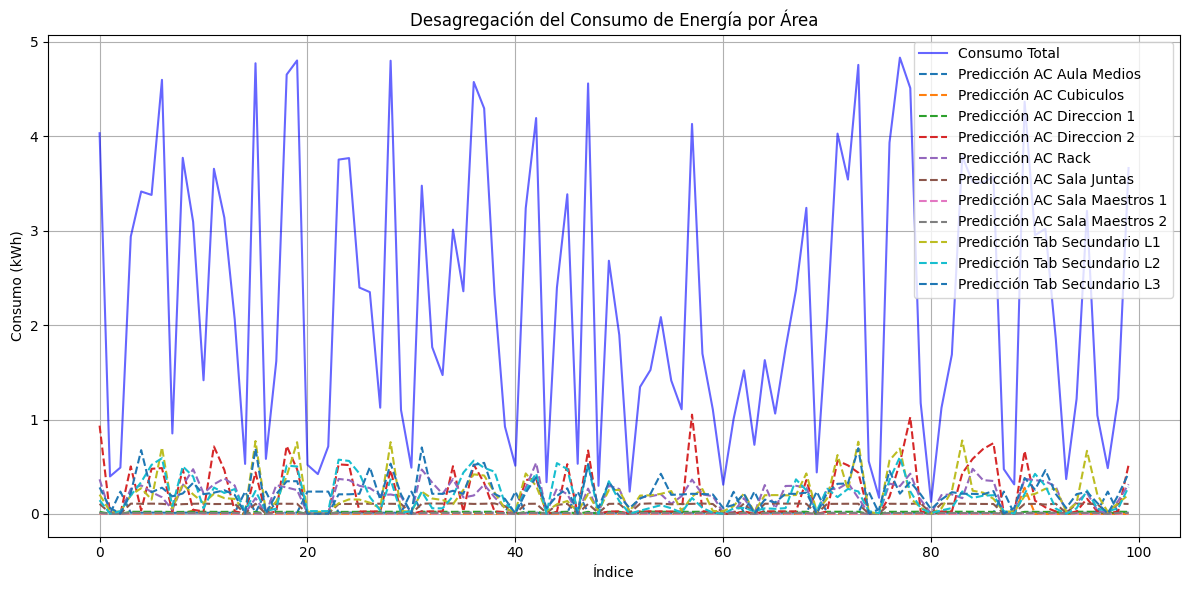

In [4]:




# Preparar los datos para el modelo
X = df[['Consumo_T']]  # Consumo total como entrada
areas = [' AC Aula Medios', ' AC Cubiculos', ' AC Direccion 1', ' AC Direccion 2', 
         ' AC Rack', ' AC Sala Juntas', ' AC Sala Maestros 1', 
         ' AC Sala Maestros 2', ' Tab Secundario L1', ' Tab Secundario L2', ' Tab Secundario L3']

# Crear y entrenar un modelo para cada área
modelos = {}
for area in areas:
    y = df[area]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Crear y entrenar el modelo para esta área
    modelo = RandomForestRegressor(n_estimators=100, random_state=42)
    modelo.fit(X_train, y_train)
    
    # Guardar el modelo entrenado
    joblib.dump(modelo, f'modelo_{area.strip()}.pkl')
    
    # Almacenar el modelo en el diccionario
    modelos[area] = modelo

# 2. Desagregar consumo de nuevos datos
def desagregar_consumo(nuevos_datos):
    # Crear un diccionario para almacenar las predicciones ajustadas
    predicciones_ajustadas = {}

    for area in areas:
        # Cargar el modelo entrenado para el área
        modelo = joblib.load(f'modelo_{area.strip()}.pkl')

        # Realizar predicciones utilizando el consumo total
        predicciones = modelo.predict(nuevos_datos[['Consumo_T']])
        predicciones_ajustadas[area] = predicciones
    
    # Convertir las predicciones ajustadas en un DataFrame
    predicciones_df = pd.DataFrame(predicciones_ajustadas)

    # Ajustar las predicciones para que sumen a 'Consumo_Total'
    predictions_total = predicciones_df.sum(axis=1)
    scaling_factor = np.where(predictions_total > nuevos_datos['Consumo_T'], 
                              nuevos_datos['Consumo_T'] / predictions_total, 1.0)
    
    # Ajustar cada predicción según el factor de escalado
    for area in areas:
        predicciones_df[area] = predicciones_df[area] * scaling_factor

    # Agregar las predicciones ajustadas al DataFrame original
    for area in areas:
        nuevos_datos[f'Consumo_{area.strip()}_Pred'] = predicciones_df[area]

    return nuevos_datos

# Crear un nuevo DataFrame con datos generales (puedes ajustar los datos reales)
df_nuevo = pd.DataFrame({
    'Consumo_T': np.random.uniform(low=0.1, high=5, size=100)  # Sustituir por datos reales
})

# Desagregar los nuevos datos
resultados = desagregar_consumo(df_nuevo)

# Mostrar resultados
print(resultados[['Consumo_T'] + [f'Consumo_{area.strip()}_Pred' for area in areas]])

# Guardar los resultados en un nuevo archivo CSV
resultados.to_csv('resultados_desagregados_universidad.csv', index=False)

# 3. Graficar los resultados de la desagregación
plt.figure(figsize=(12, 6))
plt.plot(resultados['Consumo_T'], label='Consumo Total', color='blue', alpha=0.6)

for area in areas:
    plt.plot(resultados[f'Consumo_{area.strip()}_Pred'], label=f'Predicción {area.strip()}', linestyle='--')

plt.title('Desagregación del Consumo de Energía por Área')
plt.xlabel('Índice')
plt.ylabel('Consumo (kWh)')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()
plt.show()


DESEGREGACIÓN APARTIR DE LOS MODELOS ENTRENAMOS, ESTOS SE CARGAN AQUÍ 
SE OBSERVA EN NEGRO EL CONSUMO TOTAL Y APARTIR DE ELLO SEPARA POR COLOR CADA DIPOSITIVO

Index(['Consumo_T', ' Mains_A', ' Mains_B', ' Mains_C', ' AC Sala Maestros 1',
       ' AC Direccion 1', ' AC Rack', ' AC Aula Medios', ' Tab Secundario L1',
       ' Tab Secundario L2', ' Tab Secundario L3', ' AC Sala Maestros 2',
       ' AC Direccion 2', ' AC Sala Juntas', ' AC Cubiculos'],
      dtype='object')
      Consumo_T  Aula_Medios_Pred  Cubiculos_Pred  Direccion1_Pred  \
0        7.8862          0.012656        0.585000         0.022075   
1        7.8589          0.011619        0.442513         0.022332   
2        7.8547          0.011584        0.024653         0.022229   
3        5.7020          0.013846        1.161252         0.022676   
4        5.6803          0.014203        0.429702         0.022290   
...         ...               ...             ...              ...   
9364     7.3911          0.012884        2.312106         0.021457   
9365     7.8746          0.013261        2.017375         0.022461   
9366     7.5659          0.013256        2.303416    

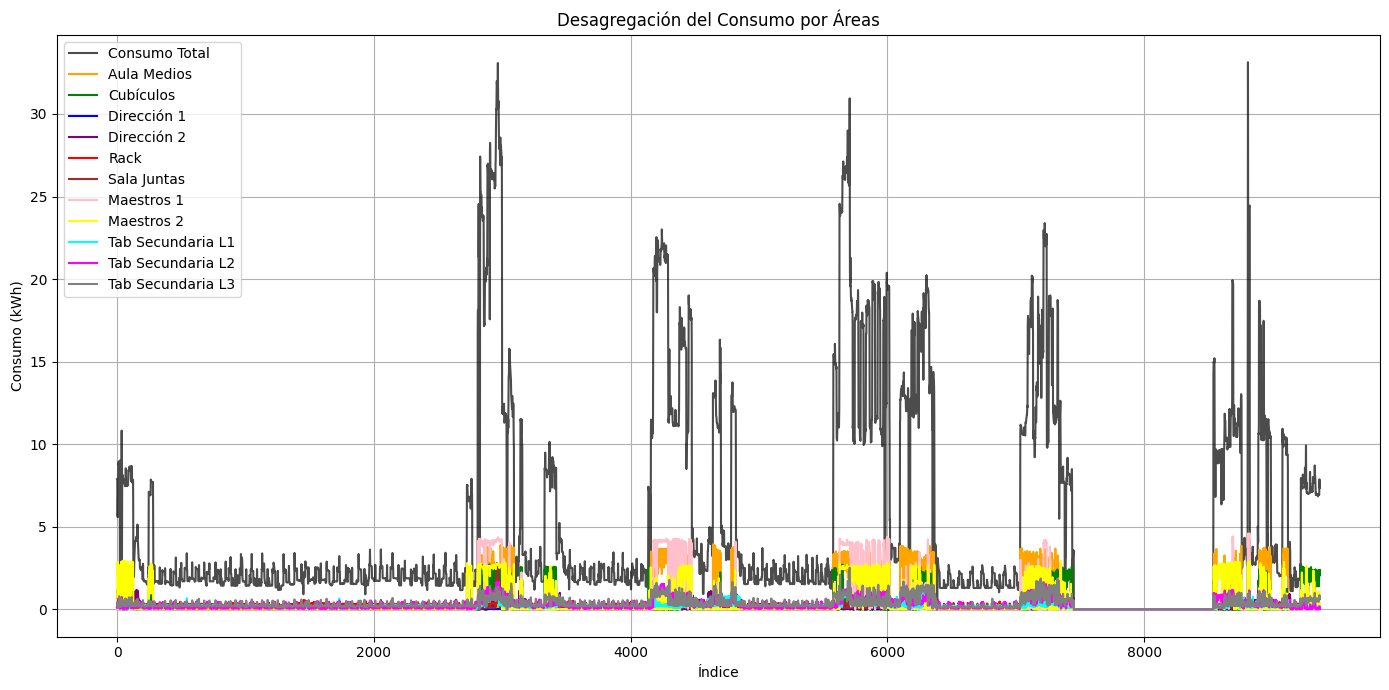

In [5]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt  # Importar matplotlib para graficar

# 1. Cargar los nuevos datos desde un archivo CSV
nuevos_datos = pd.read_csv('EF63E8-UTeM_CIER_Sala_Mestros-1MIN analizar.csv')  # Asegúrate de que la ruta sea correcta

# 2. Verificar las columnas de nuevos_datos
print(nuevos_datos.columns)  # Esto te ayudará a entender qué columnas están disponibles

# Desagregar consumo usando la función ajustada
def desagregar_consumo(nuevos_datos):
    # Cargar modelos entrenados para cada área
    
    #'modelo_Tab Secundaria L1.pkl'
    model_aula_medios = joblib.load('modelo_AC Aula Medios.pkl')
    model_cubiculos = joblib.load('modelo_AC Cubiculos.pkl')
    model_direccion1 = joblib.load('modelo_AC Direccion 1.pkl')
    model_direccion2 = joblib.load('modelo_AC Direccion 2.pkl')
    model_rack = joblib.load('modelo_AC Rack.pkl')
    model_sala_juntas = joblib.load('modelo_AC Sala Juntas.pkl')
    model_maestros1 = joblib.load('modelo_AC Sala Maestros 1.pkl')
    model_maestros2 = joblib.load('modelo_AC Sala Maestros 2.pkl')
    model_tab_l1 = joblib.load('modelo_Tab Secundario L1.pkl')
    model_tab_l2 = joblib.load('modelo_Tab Secundario L2.pkl')
    model_tab_l3 = joblib.load('modelo_Tab Secundario L3.pkl')
    
    # Realizar predicciones utilizando el consumo total
    pred_aula_medios = model_aula_medios.predict(nuevos_datos[['Consumo_T']])
    pred_cubiculos = model_cubiculos.predict(nuevos_datos[['Consumo_T']])
    pred_direccion1 = model_direccion1.predict(nuevos_datos[['Consumo_T']])
    pred_direccion2 = model_direccion2.predict(nuevos_datos[['Consumo_T']])
    pred_rack = model_rack.predict(nuevos_datos[['Consumo_T']])
    pred_sala_juntas = model_sala_juntas.predict(nuevos_datos[['Consumo_T']])
    pred_maestros1 = model_maestros1.predict(nuevos_datos[['Consumo_T']])
    pred_maestros2 = model_maestros2.predict(nuevos_datos[['Consumo_T']])
    pred_tab_l1 = model_tab_l1.predict(nuevos_datos[['Consumo_T']])
    pred_tab_l2 = model_tab_l2.predict(nuevos_datos[['Consumo_T']])
    pred_tab_l3 = model_tab_l3.predict(nuevos_datos[['Consumo_T']])

    # Sumar todas las predicciones
    predictions_total = (pred_aula_medios + pred_cubiculos + pred_direccion1 + pred_direccion2 +
                         pred_rack + pred_sala_juntas + pred_maestros1 + pred_maestros2 +
                         pred_tab_l1 + pred_tab_l2 + pred_tab_l3)
    
    # Ajustar las predicciones para que sumen a 'Consumo_T'
    scaling_factor = np.where(predictions_total > nuevos_datos['Consumo_T'], 
                              nuevos_datos['Consumo_T'] / predictions_total, 1.0)

    # Aplicar el factor de escala a cada predicción
    pred_aula_medios_ajustada = pred_aula_medios * scaling_factor
    pred_cubiculos_ajustada = pred_cubiculos * scaling_factor
    pred_direccion1_ajustada = pred_direccion1 * scaling_factor
    pred_direccion2_ajustada = pred_direccion2 * scaling_factor
    pred_rack_ajustada = pred_rack * scaling_factor
    pred_sala_juntas_ajustada = pred_sala_juntas * scaling_factor
    pred_maestros1_ajustada = pred_maestros1 * scaling_factor
    pred_maestros2_ajustada = pred_maestros2 * scaling_factor
    pred_tab_l1_ajustada = pred_tab_l1 * scaling_factor
    pred_tab_l2_ajustada = pred_tab_l2 * scaling_factor
    pred_tab_l3_ajustada = pred_tab_l3 * scaling_factor

    # Agregar las predicciones ajustadas al DataFrame
    nuevos_datos['Aula_Medios_Pred'] = pred_aula_medios_ajustada
    nuevos_datos['Cubiculos_Pred'] = pred_cubiculos_ajustada
    nuevos_datos['Direccion1_Pred'] = pred_direccion1_ajustada
    nuevos_datos['Direccion2_Pred'] = pred_direccion2_ajustada
    nuevos_datos['Rack_Pred'] = pred_rack_ajustada
    nuevos_datos['Sala_Juntas_Pred'] = pred_sala_juntas_ajustada
    nuevos_datos['Maestros1_Pred'] = pred_maestros1_ajustada
    nuevos_datos['Maestros2_Pred'] = pred_maestros2_ajustada
    nuevos_datos['Tab_L1_Pred'] = pred_tab_l1_ajustada
    nuevos_datos['Tab_L2_Pred'] = pred_tab_l2_ajustada
    nuevos_datos['Tab_L3_Pred'] = pred_tab_l3_ajustada

    return nuevos_datos

# Desagregar los nuevos datos
resultados = desagregar_consumo(nuevos_datos)

# 3. Mostrar resultados
print(resultados[['Consumo_T', 'Aula_Medios_Pred', 'Cubiculos_Pred', 'Direccion1_Pred', 
                 'Direccion2_Pred', 'Rack_Pred', 'Sala_Juntas_Pred', 'Maestros1_Pred', 
                 'Maestros2_Pred', 'Tab_L1_Pred', 'Tab_L2_Pred', 'Tab_L3_Pred']])

# Graficar los resultados
plt.figure(figsize=(14, 7))
plt.plot(resultados.index, resultados['Consumo_T'], label='Consumo Total', color='black', alpha=0.7)
plt.plot(resultados.index, resultados['Aula_Medios_Pred'], label='Aula Medios', color='orange')
plt.plot(resultados.index, resultados['Cubiculos_Pred'], label='Cubículos', color='green')
plt.plot(resultados.index, resultados['Direccion1_Pred'], label='Dirección 1', color='blue')
plt.plot(resultados.index, resultados['Direccion2_Pred'], label='Dirección 2', color='purple')
plt.plot(resultados.index, resultados['Rack_Pred'], label='Rack', color='red')
plt.plot(resultados.index, resultados['Sala_Juntas_Pred'], label='Sala Juntas', color='brown')
plt.plot(resultados.index, resultados['Maestros1_Pred'], label='Maestros 1', color='pink')
plt.plot(resultados.index, resultados['Maestros2_Pred'], label='Maestros 2', color='yellow')
plt.plot(resultados.index, resultados['Tab_L1_Pred'], label='Tab Secundaria L1', color='cyan')
plt.plot(resultados.index, resultados['Tab_L2_Pred'], label='Tab Secundaria L2', color='magenta')
plt.plot(resultados.index, resultados['Tab_L3_Pred'], label='Tab Secundaria L3', color='gray')

plt.title('Desagregación del Consumo por Áreas')
plt.xlabel('Índice')
plt.ylabel('Consumo (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Guardar los resultados en un nuevo archivo CSV
resultados.to_csv('resultados_desagregados_datos_uni.csv', index=False)


AQUI SE OBSERVA MÁS A DETALLE EL COMPORTAMIENTO DE CADA DISPOSITIVO EN EL TRANSCURSO DEL TIEMPO

Index(['Consumo_T', ' Mains_A', ' Mains_B', ' Mains_C', ' AC Sala Maestros 1',
       ' AC Direccion 1', ' AC Rack', ' AC Aula Medios', ' Tab Secundario L1',
       ' Tab Secundario L2', ' Tab Secundario L3', ' AC Sala Maestros 2',
       ' AC Direccion 2', ' AC Sala Juntas', ' AC Cubiculos'],
      dtype='object')
      Consumo_T  Aula_Medios_Pred  Cubiculos_Pred  Direccion1_Pred  \
0        7.8862          0.012656        0.585000         0.022075   
1        7.8589          0.011619        0.442513         0.022332   
2        7.8547          0.011584        0.024653         0.022229   
3        5.7020          0.013846        1.161252         0.022676   
4        5.6803          0.014203        0.429702         0.022290   
...         ...               ...             ...              ...   
9364     7.3911          0.012884        2.312106         0.021457   
9365     7.8746          0.013261        2.017375         0.022461   
9366     7.5659          0.013256        2.303416    

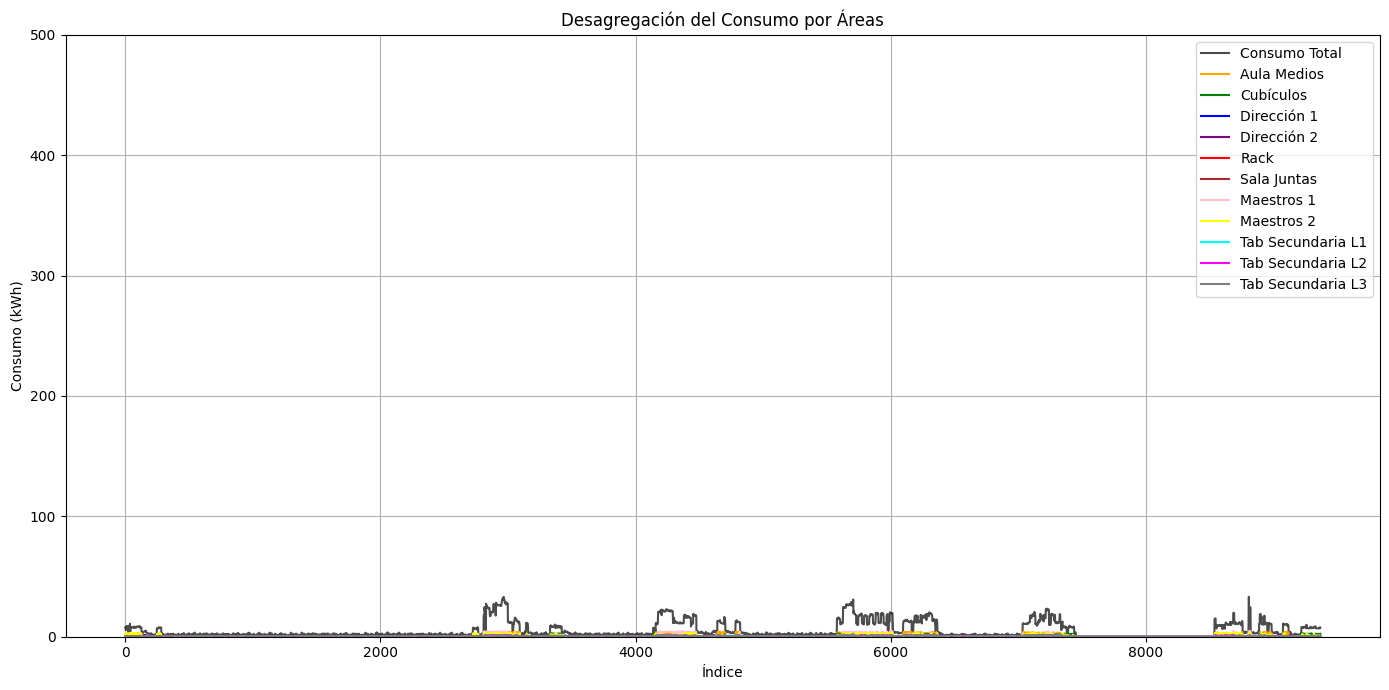

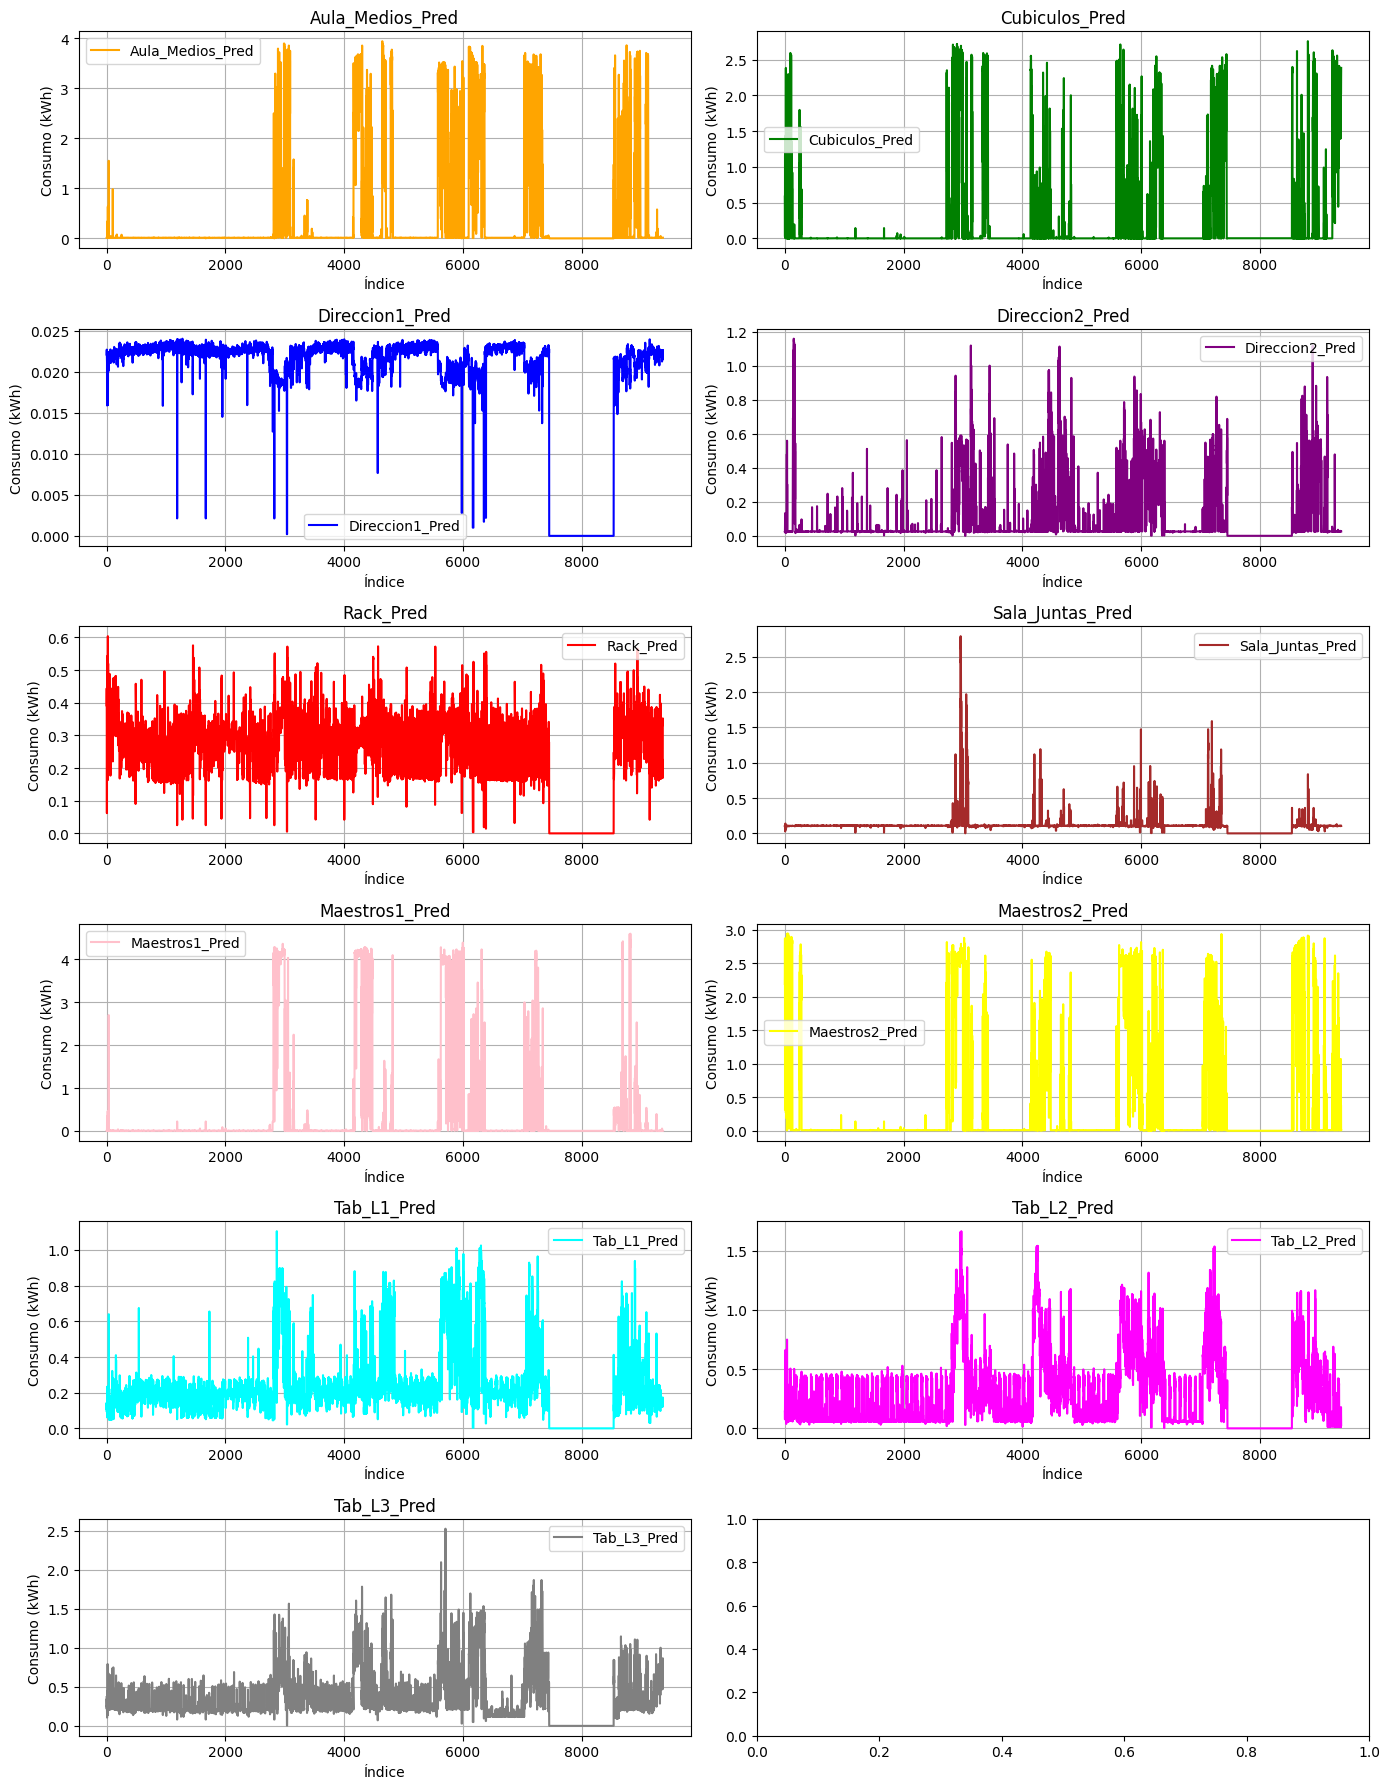

In [6]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt  # Importar matplotlib para graficar

# 1. Cargar los nuevos datos desde un archivo CSV
nuevos_datos = pd.read_csv('EF63E8-UTeM_CIER_Sala_Mestros-1MIN analizar.csv')  # Asegúrate de que la ruta sea correcta

# 2. Verificar las columnas de nuevos_datos
print(nuevos_datos.columns)  # Esto te ayudará a entender qué columnas están disponibles

# Desagregar consumo usando la función ajustada
def desagregar_consumo(nuevos_datos):
    # Cargar modelos entrenados para cada área
    model_aula_medios = joblib.load('modelo_AC Aula Medios.pkl')
    model_cubiculos = joblib.load('modelo_AC Cubiculos.pkl')
    model_direccion1 = joblib.load('modelo_AC Direccion 1.pkl')
    model_direccion2 = joblib.load('modelo_AC Direccion 2.pkl')
    model_rack = joblib.load('modelo_AC Rack.pkl')
    model_sala_juntas = joblib.load('modelo_AC Sala Juntas.pkl')
    model_maestros1 = joblib.load('modelo_AC Sala Maestros 1.pkl')
    model_maestros2 = joblib.load('modelo_AC Sala Maestros 2.pkl')
    model_tab_l1 = joblib.load('modelo_Tab Secundario L1.pkl')
    model_tab_l2 = joblib.load('modelo_Tab Secundario L2.pkl')
    model_tab_l3 = joblib.load('modelo_Tab Secundario L3.pkl')

    # Realizar predicciones utilizando el consumo total
    pred_aula_medios = model_aula_medios.predict(nuevos_datos[['Consumo_T']])
    pred_cubiculos = model_cubiculos.predict(nuevos_datos[['Consumo_T']])
    pred_direccion1 = model_direccion1.predict(nuevos_datos[['Consumo_T']])
    pred_direccion2 = model_direccion2.predict(nuevos_datos[['Consumo_T']])
    pred_rack = model_rack.predict(nuevos_datos[['Consumo_T']])
    pred_sala_juntas = model_sala_juntas.predict(nuevos_datos[['Consumo_T']])
    pred_maestros1 = model_maestros1.predict(nuevos_datos[['Consumo_T']])
    pred_maestros2 = model_maestros2.predict(nuevos_datos[['Consumo_T']])
    pred_tab_l1 = model_tab_l1.predict(nuevos_datos[['Consumo_T']])
    pred_tab_l2 = model_tab_l2.predict(nuevos_datos[['Consumo_T']])
    pred_tab_l3 = model_tab_l3.predict(nuevos_datos[['Consumo_T']])

    # Sumar todas las predicciones
    predictions_total = (pred_aula_medios + pred_cubiculos + pred_direccion1 + pred_direccion2 +
                         pred_rack + pred_sala_juntas + pred_maestros1 + pred_maestros2 +
                         pred_tab_l1 + pred_tab_l2 + pred_tab_l3)

    # Ajustar las predicciones para que sumen a 'Consumo_T'
    scaling_factor = np.where(predictions_total > nuevos_datos['Consumo_T'], 
                              nuevos_datos['Consumo_T'] / predictions_total, 1.0)

    # Aplicar el factor de escala a cada predicción
    pred_aula_medios_ajustada = pred_aula_medios * scaling_factor
    pred_cubiculos_ajustada = pred_cubiculos * scaling_factor
    pred_direccion1_ajustada = pred_direccion1 * scaling_factor
    pred_direccion2_ajustada = pred_direccion2 * scaling_factor
    pred_rack_ajustada = pred_rack * scaling_factor
    pred_sala_juntas_ajustada = pred_sala_juntas * scaling_factor
    pred_maestros1_ajustada = pred_maestros1 * scaling_factor
    pred_maestros2_ajustada = pred_maestros2 * scaling_factor
    pred_tab_l1_ajustada = pred_tab_l1 * scaling_factor
    pred_tab_l2_ajustada = pred_tab_l2 * scaling_factor
    pred_tab_l3_ajustada = pred_tab_l3 * scaling_factor

    # Agregar las predicciones ajustadas al DataFrame
    nuevos_datos['Aula_Medios_Pred'] = pred_aula_medios_ajustada
    nuevos_datos['Cubiculos_Pred'] = pred_cubiculos_ajustada
    nuevos_datos['Direccion1_Pred'] = pred_direccion1_ajustada
    nuevos_datos['Direccion2_Pred'] = pred_direccion2_ajustada
    nuevos_datos['Rack_Pred'] = pred_rack_ajustada
    nuevos_datos['Sala_Juntas_Pred'] = pred_sala_juntas_ajustada
    nuevos_datos['Maestros1_Pred'] = pred_maestros1_ajustada
    nuevos_datos['Maestros2_Pred'] = pred_maestros2_ajustada
    nuevos_datos['Tab_L1_Pred'] = pred_tab_l1_ajustada
    nuevos_datos['Tab_L2_Pred'] = pred_tab_l2_ajustada
    nuevos_datos['Tab_L3_Pred'] = pred_tab_l3_ajustada

    return nuevos_datos

# Desagregar los nuevos datos
resultados = desagregar_consumo(nuevos_datos)

# 3. Mostrar resultados
print(resultados[['Consumo_T', 'Aula_Medios_Pred', 'Cubiculos_Pred', 'Direccion1_Pred', 
                 'Direccion2_Pred', 'Rack_Pred', 'Sala_Juntas_Pred', 'Maestros1_Pred', 
                 'Maestros2_Pred', 'Tab_L1_Pred', 'Tab_L2_Pred', 'Tab_L3_Pred']])

# Opción 1: Ajustar el rango del eje Y para hacer zoom
plt.figure(figsize=(14, 7))
plt.plot(resultados.index, resultados['Consumo_T'], label='Consumo Total', color='black', alpha=0.7)
plt.plot(resultados.index, resultados['Aula_Medios_Pred'], label='Aula Medios', color='orange')
plt.plot(resultados.index, resultados['Cubiculos_Pred'], label='Cubículos', color='green')
plt.plot(resultados.index, resultados['Direccion1_Pred'], label='Dirección 1', color='blue')
plt.plot(resultados.index, resultados['Direccion2_Pred'], label='Dirección 2', color='purple')
plt.plot(resultados.index, resultados['Rack_Pred'], label='Rack', color='red')
plt.plot(resultados.index, resultados['Sala_Juntas_Pred'], label='Sala Juntas', color='brown')
plt.plot(resultados.index, resultados['Maestros1_Pred'], label='Maestros 1', color='pink')
plt.plot(resultados.index, resultados['Maestros2_Pred'], label='Maestros 2', color='yellow')
plt.plot(resultados.index, resultados['Tab_L1_Pred'], label='Tab Secundaria L1', color='cyan')
plt.plot(resultados.index, resultados['Tab_L2_Pred'], label='Tab Secundaria L2', color='magenta')
plt.plot(resultados.index, resultados['Tab_L3_Pred'], label='Tab Secundaria L3', color='gray')

plt.title('Desagregación del Consumo por Áreas')
plt.xlabel('Índice')
plt.ylabel('Consumo (kWh)')
plt.legend()
plt.grid()

# Ajustar el eje Y para hacer zoom (por ejemplo, entre 0 y 500 kWh)
plt.ylim(0, 500)  # Cambia los valores según lo que quieras visualizar más detalladamente

plt.tight_layout()
plt.show()

# Opción 2: Subgráficas individuales para cada área
fig, axes = plt.subplots(6, 2, figsize=(14, 18))  # 6 filas, 2 columnas para incluir todas las áreas
areas = ['Aula_Medios_Pred', 'Cubiculos_Pred', 'Direccion1_Pred', 'Direccion2_Pred', 
         'Rack_Pred', 'Sala_Juntas_Pred', 'Maestros1_Pred', 'Maestros2_Pred',
         'Tab_L1_Pred', 'Tab_L2_Pred', 'Tab_L3_Pred']
colors = ['orange', 'green', 'blue', 'purple', 'red', 'brown', 'pink', 'yellow', 'cyan', 'magenta', 'gray']

for i, area in enumerate(areas):
    ax = axes[i//2, i%2]  # Acceder a la subgráfica correspondiente
    ax.plot(resultados.index, resultados[area], label=area, color=colors[i])
    ax.set_title(area)
    ax.set_xlabel('Índice')
    ax.set_ylabel('Consumo (kWh)')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

